# Title:Non deep learning based methods for image segmentations
The aim of this project to show k-means, fuzzy c-means and mean shift algorithms for image segmentation.

# Importing libraries

In [5]:
import os
import random
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Helper functions

In [3]:
# read an 3 channel image as input array
def get_image(img):
    im = Image.open(img).convert('L')
    out = im.resize((256, 256),Image.ANTIALIAS)   
    arr_img = np.asarray(out)
    return arr_img

# helper function to show the segmentation results from k-means and fuzzy c-means algorithms
def show_results(orig,seg,K,fname):
    plt.figure()
    ax1 =plt.subplot(121)
    ax2 =plt.subplot(122)
    ax1.set_title('Original Image')
    ax1.imshow(orig)
    ax2.set_title('Result of segmented image \nwith K = {}'.format(K))
    ax2.imshow(seg)    
    plt.show()
    
# helper function to show the segmentation results from mean-shift algorithm   
def show_results_meanshift(orig,seg,rad,kernel,fname):
    plt.figure()
    ax1 =plt.subplot(121)
    ax2 =plt.subplot(122)
    ax1.set_title('Original Image')
    ax1.imshow(orig)
    ax2.set_title('Result of segmented image with\n Parzen window size ={}\n and kernel {}'.format(rad,kernel))
    ax2.imshow(seg)    
    plt.show() 

# K-means Algorithm

In [7]:
def assign_cluster(data_arr,mediods):
    dists = np.zeros((data_arr.shape[0],len(mediods)))
    
    for i in range(mediods.shape[0]):
        diff = data_arr - mediods[i]
        dists[:,i] = np.linalg.norm(diff,axis=1)
    cluster_nos= np.argmin(dists,axis=1).reshape(data_arr.shape[0],1)
    data_arr = np.concatenate([data_arr,cluster_nos],axis=1)
    return data_arr
    
def calc_cost(clus_data_arr,means):
    cost =0
    for j in range(means.shape[0]): 
        clus =clus_data_arr[np.where(clus_data_arr[:,-1] == j)][:,:-1]
        mean=means[j]
        cost+=np.sum(np.linalg.norm(clus -mean,axis=1))
    return cost
           
def calc_mean_kmeans(clus_data_arr,means):
    new_means =[]
    for j in range(means.shape[0]): 
        clus =clus_data_arr[np.where(clus_data_arr[:,-1] == j)][:,:-1]
        new_mean = np.mean(clus,axis=0)
        new_means.append(new_mean)
    new_means = np.array(new_means)
    return new_means

def k_means(data_arr,k,get_stat=False):
    iters=1
    mean_indx = np.random.choice(data_arr.shape[0],k,replace=False) 
    means = data_arr[mean_indx]
    clus_data_arr=None
    cost_arr =[]
    
    while(iters<200):
        clus_data_arr = assign_cluster(data_arr,means)
        means_new = calc_mean_kmeans(clus_data_arr,means)
        if (np.array_equal(means,means_new)):
            break
        means = means_new
        if(get_stat):    
            cost = calc_cost(clus_data_arr,means)
            cost_arr.append((iters,cost))
        iters+=1  
    return clus_data_arr

# Fuzzy C-means Algorithm

In [19]:
def init_membership_mat(pixel_range,cls_range):
    mat = np.random.random((pixel_range,cls_range))
    rsum = np.sum(mat,axis=1)
    mat = mat /rsum[:,np.newaxis] 
    return mat

def generate_clusters(pix_range,count,clus_list):
    clusters=[]
    div_list=[]
    div_list.append(0)
    
    for k in range(len(clus_list)-1):
        div_list.append((clus_list[k]+clus_list[k+1])/2)
    div_list.append(256)
    div_list = list(map(int,div_list))
  
    for k in range(len(div_list)-1):
        clusters.append(pix_range[div_list[k]: div_list[k+1]])
    
    return clusters
    
def calc_mean_fcm(clusters,count,V,r):
    means=[]
    for j in range(len(clusters)):
        weights = np.array([count[int(i)] for i in clusters[j]])
        mem_v  =  np.array([V[int(i)] for i in clusters[j]])
        clus_mean = int(np.sum(clusters[j]*weights*np.power(mem_v[:,j],r))/np.sum(weights*np.power(mem_v[:,j],r)))
        means.append(clus_mean)
    return np.array(means)
        
        
def calc_membership_mat(pix_range,means,r):
    d_mat = np.zeros((pix_range.shape[0],means.shape[0]))
    V =  np.zeros(d_mat.shape)
    for j in range(len(means)):
        v_j= np.abs(pix_range - means[j])
        v_j[np.where(v_j == 0)] = 1
        d_mat[:,j]=v_j
    d_mat = np.power(d_mat,2/(r-1))
    
    for j in range(d_mat.shape[1]):
        p = np.sum(np.array([d_mat[:,j]/d_mat[:,k] for k in range(d_mat.shape[1])]),axis=0)
        V[:,j]=1/p
    return V
        
    
def fcm(pix_range,count,C):

    means=np.array(random.sample(range(0, 255),C))
    V = None
    clusters=None
    err_tol = 1e-5
    iters=0
    error=1e5
    while(error > err_tol and iters<200):    
        means.sort()
        V = calc_membership_mat(pix_range,means,2)
        clusters = generate_clusters(pix_range,count,means)
        means_new = calc_mean_fcm(clusters,count,V,2)
        error = np.linalg.norm(means_new-means)
        means = means_new 
        iters+=1
        
    return [clusters,V]
    

def fuzzy_cmeans(arr_img,K=2,get_stat = False):   
    count,bins = np.histogram(arr_img,256,[0,256])
    clusters,V = fcm(bins,count,K) #fcm algorithm for 2 clusters
    seg = np.zeros(arr_img.shape)
    for i in range(arr_img.shape[0]):
        for j in range(arr_img.shape[1]):
            seg[i][j] = arr_img[i][j]*V[arr_img[i][j],1]*255
    return seg

# Mean Shift Algorithm

In [13]:

def assign_cluster(data_arr,means):
    dists = np.zeros((data_arr.shape[0],len(means)))
    
    for i in range(means.shape[0]):
        diff = data_arr - means[i]
        dists[:,i] = np.linalg.norm(diff,axis=1)
    cluster_nos= np.argmin(dists,axis=1).reshape(data_arr.shape[0],1)
    data_arr = np.concatenate([data_arr,cluster_nos],axis=1)
    return data_arr


#gaussian mean for calculating density in epsilon negihobour
def calc_density_mean(neig,seed,rad):
    weights = np.exp(-1*np.linalg.norm((neig-seed)/rad,axis=1))
    mean = np.array(np.sum(weights[:,None]*neig,axis=0)/np.sum(weights),dtype=np.int64)
    return mean


def coalesce_means(means,bandwidth):
    flags = [1 for me in means]
    for i in range(len(means)):
        if flags[i] == 1:
            w = 1.0
            j = i + 1
            while j < len(means):
                dsm = np.linalg.norm(means[i] - means[j])
                if dsm < bandwidth:
                    means[i] = means[i] + means[j]
                    w = w + 1.0
                    flags[j] = 0
                j = j + 1
            means[i] = means[i]/w
    converged_means = []
    for i in range(len(means)):
        if flags[i] == 1:
            converged_means.append(means[i])
    converged_means = np.array(converged_means)
    return converged_means


def dbindex(clus_data_arr,means):
    cost =0
    for j in range(means.shape[0]): 
        clus =clus_data_arr[np.where(clus_data_arr[:,-1] == j)][:,:-1]
        mean=means[j]
        cost+=np.sum(np.linalg.norm(clus -mean,axis=1))
    
    return cost
           
#function of kernel density estimation
def kde(data_arr,mean_indx,rad,kernel):
    means = data_arr[mean_indx]
    
    iters=0
    while(True):
        new_means =[]
        for indx in range(means.shape[0]):
            mean =means[indx]
            dist = np.linalg.norm(data_arr - mean,axis=1)
            neig = data_arr[np.where(dist < rad)]
            if kernel == 'gaussian':    
                new_mean = calc_density_mean(neig,mean,rad)
            new_means.append(new_mean)
        new_means = np.array(new_means)
        if np.array_equal(new_mean,mean):
            break
        means = new_means
        iters+=1
    return means



def mean_shift(arr_img,rad,no_probes=50,kernel='gaussian'):
    #handling grayscale vs color case
    if (len(arr_img.shape) == 2):
        w,h = arr_img.shape
        data_arr = arr_img.reshape((w*h,1))
    elif(len(arr_img.shape) == 3):
        w,h,d = arr_img.shape
        data_arr = arr_img.reshape((w*h,d))    
    
    #selecting random means given by k
    mean_indx = np.random.choice(data_arr.shape[0],no_probes,replace=True)
    #performing kde for each mean
    kde_means = kde(data_arr,mean_indx,rad,kernel)
    #assigning the clusters
    clus_data_arr = assign_cluster(data_arr,kde_means)
    #merging clusters
    final_means = coalesce_means(kde_means,rad)
    clus_data_arr = assign_cluster(data_arr,final_means)
    clus_data_arr_orig = assign_cluster(data_arr,final_means)
    
    #for each mean and its corresponding cluster
    for k in range(final_means.shape[0]):
        idx = np.where(clus_data_arr[:,-1] == k)
        clus_data_arr[idx,:-1]=final_means[k]
        
    #showing the final clustered image
    data_arr = clus_data_arr[:,:-1]
    data_arr= data_arr.reshape(arr_img.shape)    
    return data_arr

# 1. Showing results on scenery image

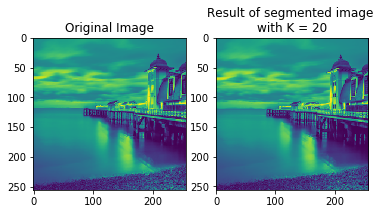

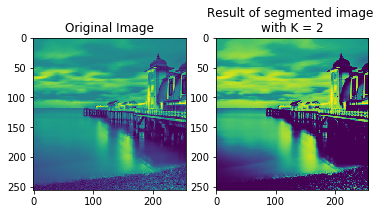

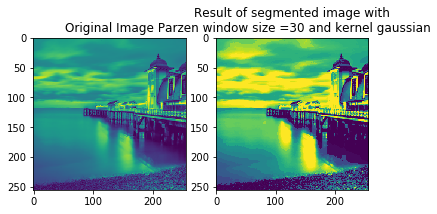

In [32]:
arr_img =get_image(os.path.join('data','scenery.jpg'))
seg_img = k_means(arr_img,k=20)
show_results(arr_img,seg_img,K=20,fname='scenery')

arr_img =get_image(os.path.join('data','scenery.jpg'))
seg_img = fuzzy_cmeans(arr_img,K=2)
show_results(arr_img,seg_img,K=2,fname='scenery')

arr_img =get_image(os.path.join('data','scenery.jpg'))
seg_img = mean_shift(arr_img,rad=30,no_probes=150,kernel='gaussian')
show_results_meanshift(arr_img,seg_img,rad=30,kernel='gaussian',fname='blob')

# 2. Showing results on crow image

arr_img =get_image(os.path.join('data','input2.jpg'))
seg_img = k_means(arr_img,k=20)
show_results(arr_img,seg_img,K=20,fname='input2')

arr_img =get_image(os.path.join('data','input2.jpg'))
seg_img = fuzzy_cmeans(arr_img,K=2)
show_results(arr_img,seg_img,K=2,fname='input2')

arr_img =get_image(os.path.join('data','input2.jpg'))
seg_img = mean_shift(arr_img,rad=30,no_probes=150,kernel='gaussian')
show_results_meanshift(arr_img,seg_img,rad=30,kernel='gaussian',fname='blob')

# 3. Showing results on ring image

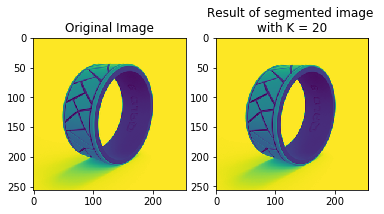

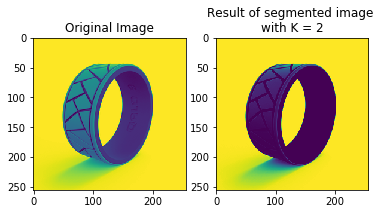

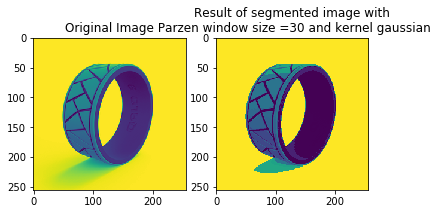

In [39]:
arr_img =get_image(os.path.join('data','t1.png'))
seg_img = k_means(arr_img,k=20)
show_results(arr_img,seg_img,K=20,fname='t1')

arr_img =get_image(os.path.join('data','t1.png'))
seg_img = fuzzy_cmeans(arr_img,K=2)
show_results(arr_img,seg_img,K=2,fname='t1')

arr_img =get_image(os.path.join('data','t1.png'))
seg_img = mean_shift(arr_img,rad=30,no_probes=150,kernel='gaussian')
show_results_meanshift(arr_img,seg_img,rad=30,kernel='gaussian',fname='blob')

# 4. Showing results on cloud image

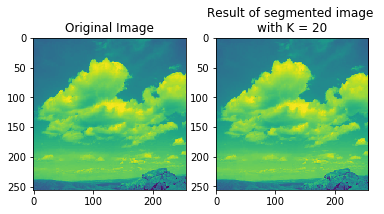

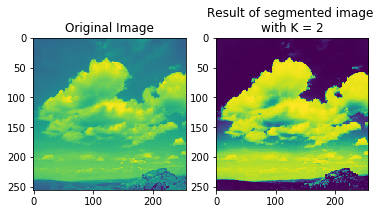

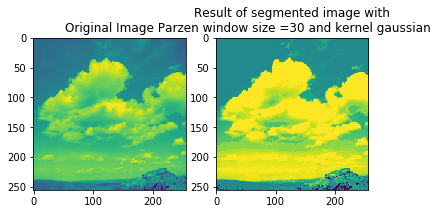

In [40]:
arr_img =get_image(os.path.join('data','Cloud.jpg'))
seg_img = k_means(arr_img,k=20)
show_results(arr_img,seg_img,K=20,fname='Cloud')

arr_img =get_image(os.path.join('data','Cloud.jpg'))
seg_img = fuzzy_cmeans(arr_img,K=2)
show_results(arr_img,seg_img,K=2,fname='Cloud')

arr_img =get_image(os.path.join('data','Cloud.jpg'))
seg_img = mean_shift(arr_img,rad=30,no_probes=1500,kernel='gaussian')
show_results_meanshift(arr_img,seg_img,rad=30,kernel='gaussian',fname='blob')